In [1]:
import pandas as pd
import opendatasets as od

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt
import seaborn as sns

import math
import numpy as np

import folium

## Import Data

In [2]:
# import os
# kaggleDict = {"username":"treyhannam",
#               "key":""}
# od.download('https://www.kaggle.com/mikeshout/14erpeaks')
# os.rename('14er.csv', 'fourteener.csv')

In [3]:
df = pd.read_csv(r'../fourteener.csv',encoding='ANSI', index_col='ID')

In [4]:
df.head()

Mountain Peak          Mountain Range  Elevation_ft fourteener  \
ID                                                                   
1    Mount Elbert           Sawatch Range         14440          Y   
2   Mount Massive           Sawatch Range         14428          Y   
3   Mount Harvard           Sawatch Range         14421          Y   
4     Blanca Peak  Sangre de Cristo Range         14351          Y   
5   La Plata Peak           Sawatch Range         14343          Y   

    Prominence_ft  Isolation_mi      Lat      Long    Standard Route  \
ID                                                                     
1            9093        670.00  39.1178 -106.4454  Northeast Ridge    
2            1961          5.06  39.1875 -106.4757      East Slopes    
3            2360         14.93  38.9244 -106.3207     South Slopes    
4            5326        103.40  37.5775 -105.4856  Northwest Ridge    
5            1836          6.28  39.0294 -106.4729  Northwest Ridge    

    Distance_mi  Elevation Gain_ft    Difficulty  Traffic Low  Traffic High  \
ID                                                                            
1          9.50               4700       Class 1        20000         25000   
2         14.50               4500       Class 2         7000         10000   
3         14.00               4600       Class 2         5000          7000   
4         17.00               6500  Hard Class 2         1000          3000   
5          9.25               4500       Class 2         5000          7000   

                                                photo  
ID                                                     
1   https://www.14ers.com/photos/mtelbert/peakphot...  
2   https://www.14ers.com/photos/mtmassive/peakpho...  
3   https://www.14ers.com/photos/harvardgroup/peak...  
4   https://www.14ers.com/photos/blancagroup/peakp...  
5   https://www.14ers.com/photos/laplatapeak/peakp...

## Normalize Values
This is being done to scale all the measures of a 14er to allow comparison across each mountain using polar plots. As shown in Figure 1 it is easy to compare one mountain to another for multiple data points.

In [5]:
categorized_df = df.copy()

##### Calss Difficulty

In [6]:
categorizeClassRank = {
    'Class 1' : 1,
    'Class 2' : 2,
    'Hard Class 2' : 3,
    'Easy Class 3' : 4,
    'Class 3' : 5,
    'Hard Class 3' : 6,
    'Class 4' : 7
}

In [7]:
for k,v in categorizeClassRank.items():
    categorized_df['Difficulty'].loc[ categorized_df['Difficulty'] == k] = v

C:\Users\Trey\Desktop\Python\14er Project\14ervenv\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


#### Trail Distance (Distance_mi), Elevation and Visitors

In [8]:
# normalize then scale to categorical variable
categorized_df['Distance_mi'] = 7*( categorized_df['Distance_mi']/ categorized_df['Distance_mi'].max() )

In [9]:
categorized_df['Elevation Gain_ft'] = 7*( categorized_df['Elevation Gain_ft']/ categorized_df['Elevation Gain_ft'].max() )

In [10]:
categorized_df['Traffic High'] = 7*( categorized_df['Traffic High']/ categorized_df['Traffic High'].max() )

### Plot 14ers

In [11]:
hikesIhaveDone = ['Longs Peak', 'Pikes Peak', 'Humboldt Peak', 'Mount Bierstadt', 'Mount Evans', 'Mount Bross', 'Mount Democrat', 'Crestone Peak', 'Crestone Needle']

In [12]:
'''Given a list, it will format and create polar plots for each element'''
def multiPolarPlot(mtnList):    
    plotCount = len(mtnList)
    figRows = int( math.ceil( plotCount/3) )

    fig = make_subplots(rows=figRows, cols=3, specs=[ [{'type': 'polar'}]*3 ]*figRows, horizontal_spacing=.2, subplot_titles=mtnList)

    for mtn in mtnList:
        row = 1+(mtnList.index(mtn)%3) # rows
        col = int( round( .6+(mtnList.index(mtn)/3), 0) ) 

        polar= "polar"+str( mtnList.index(mtn)+1 )

        peak_df = categorized_df.loc[ categorized_df['Mountain Peak'] == mtn]

        fig.add_trace(
        go.Scatterpolar(
                name = mtn,
                mode = "lines",
                theta = ['Difficulty', 'Distance (mi)', 'Elevation Gain (ft)', 'Traffic High', 'Difficulty'],
                r = (peak_df['Difficulty'].values[0], peak_df['Distance_mi'].values[0],
                        peak_df['Elevation Gain_ft'].values[0], peak_df['Traffic High'].values[0],
                        peak_df['Difficulty'].values[0]),
                fill = "toself",
                line =dict( shape = 'spline'),
                subplot = polar,
                ), col, row)

    fig.update_polars(radialaxis=dict(
        visible=True,
        range=[0, 7.5],
        showticklabels = False))
    fig.update_annotations(yshift=20)
    if plotCount > 3:
        fig.update_layout(height=1000*1, width=2000)
    elif plotCount > 9:
        fig.update_layout(height=1000*(plotCount//10), width=2000)
    fig.update_layout(title_text="Figure 1: Polar Plots of 14ers", title_x=0.25)
    fig.show()

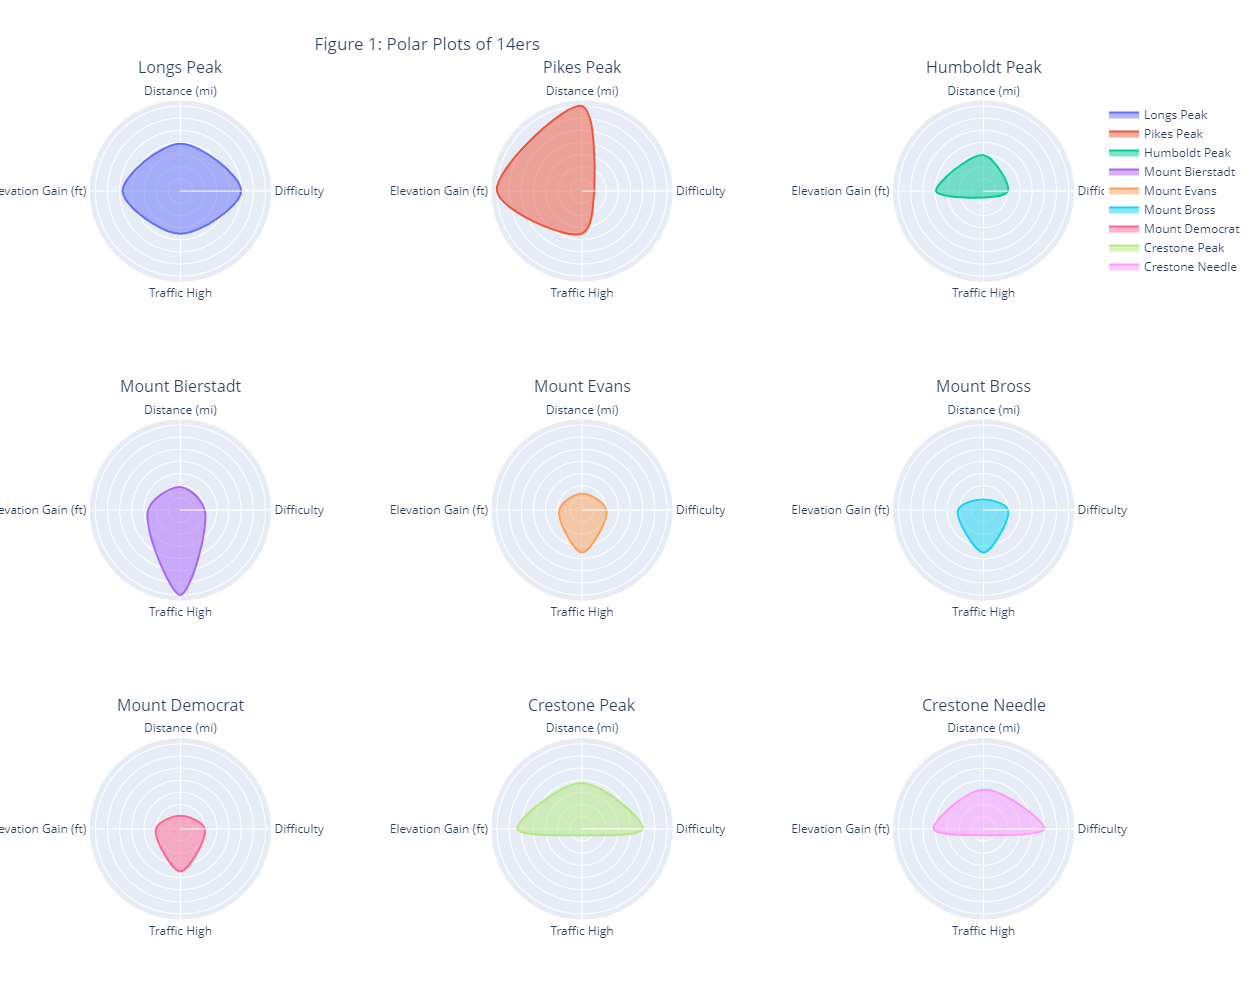

In [13]:
multiPolarPlot(hikesIhaveDone)

### EDA for Modeling
The motivation here is to find the best predictors for how much traffic a 14er sees. In Figure 2 I didn't see any obvious patterns in the data that would aid modeling. However, Figure 3 showed that there is a moderate correlation between difficulty and lattitude regarding traffic. Notably, I excluded elevation gain and distance because they are captured within the ranking system for difficulty. To best explain the relationship between lattitude and traffic, I mapped the mountain locations, roadway I-70, and color coded popularity. I-70 is a roadway that extends from Colorado's most populated city. So, the closer a mountain is to I-70 the more convenient it is to access.

In [14]:
df_modeling = df.copy()

In [15]:
for k,v in categorizeClassRank.items():
    df_modeling['Difficulty'].loc[ df_modeling['Difficulty'] == k] = v

C:\Users\Trey\Desktop\Python\14er Project\14ervenv\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [16]:
df_modeling = df_modeling.astype({"Difficulty": int})

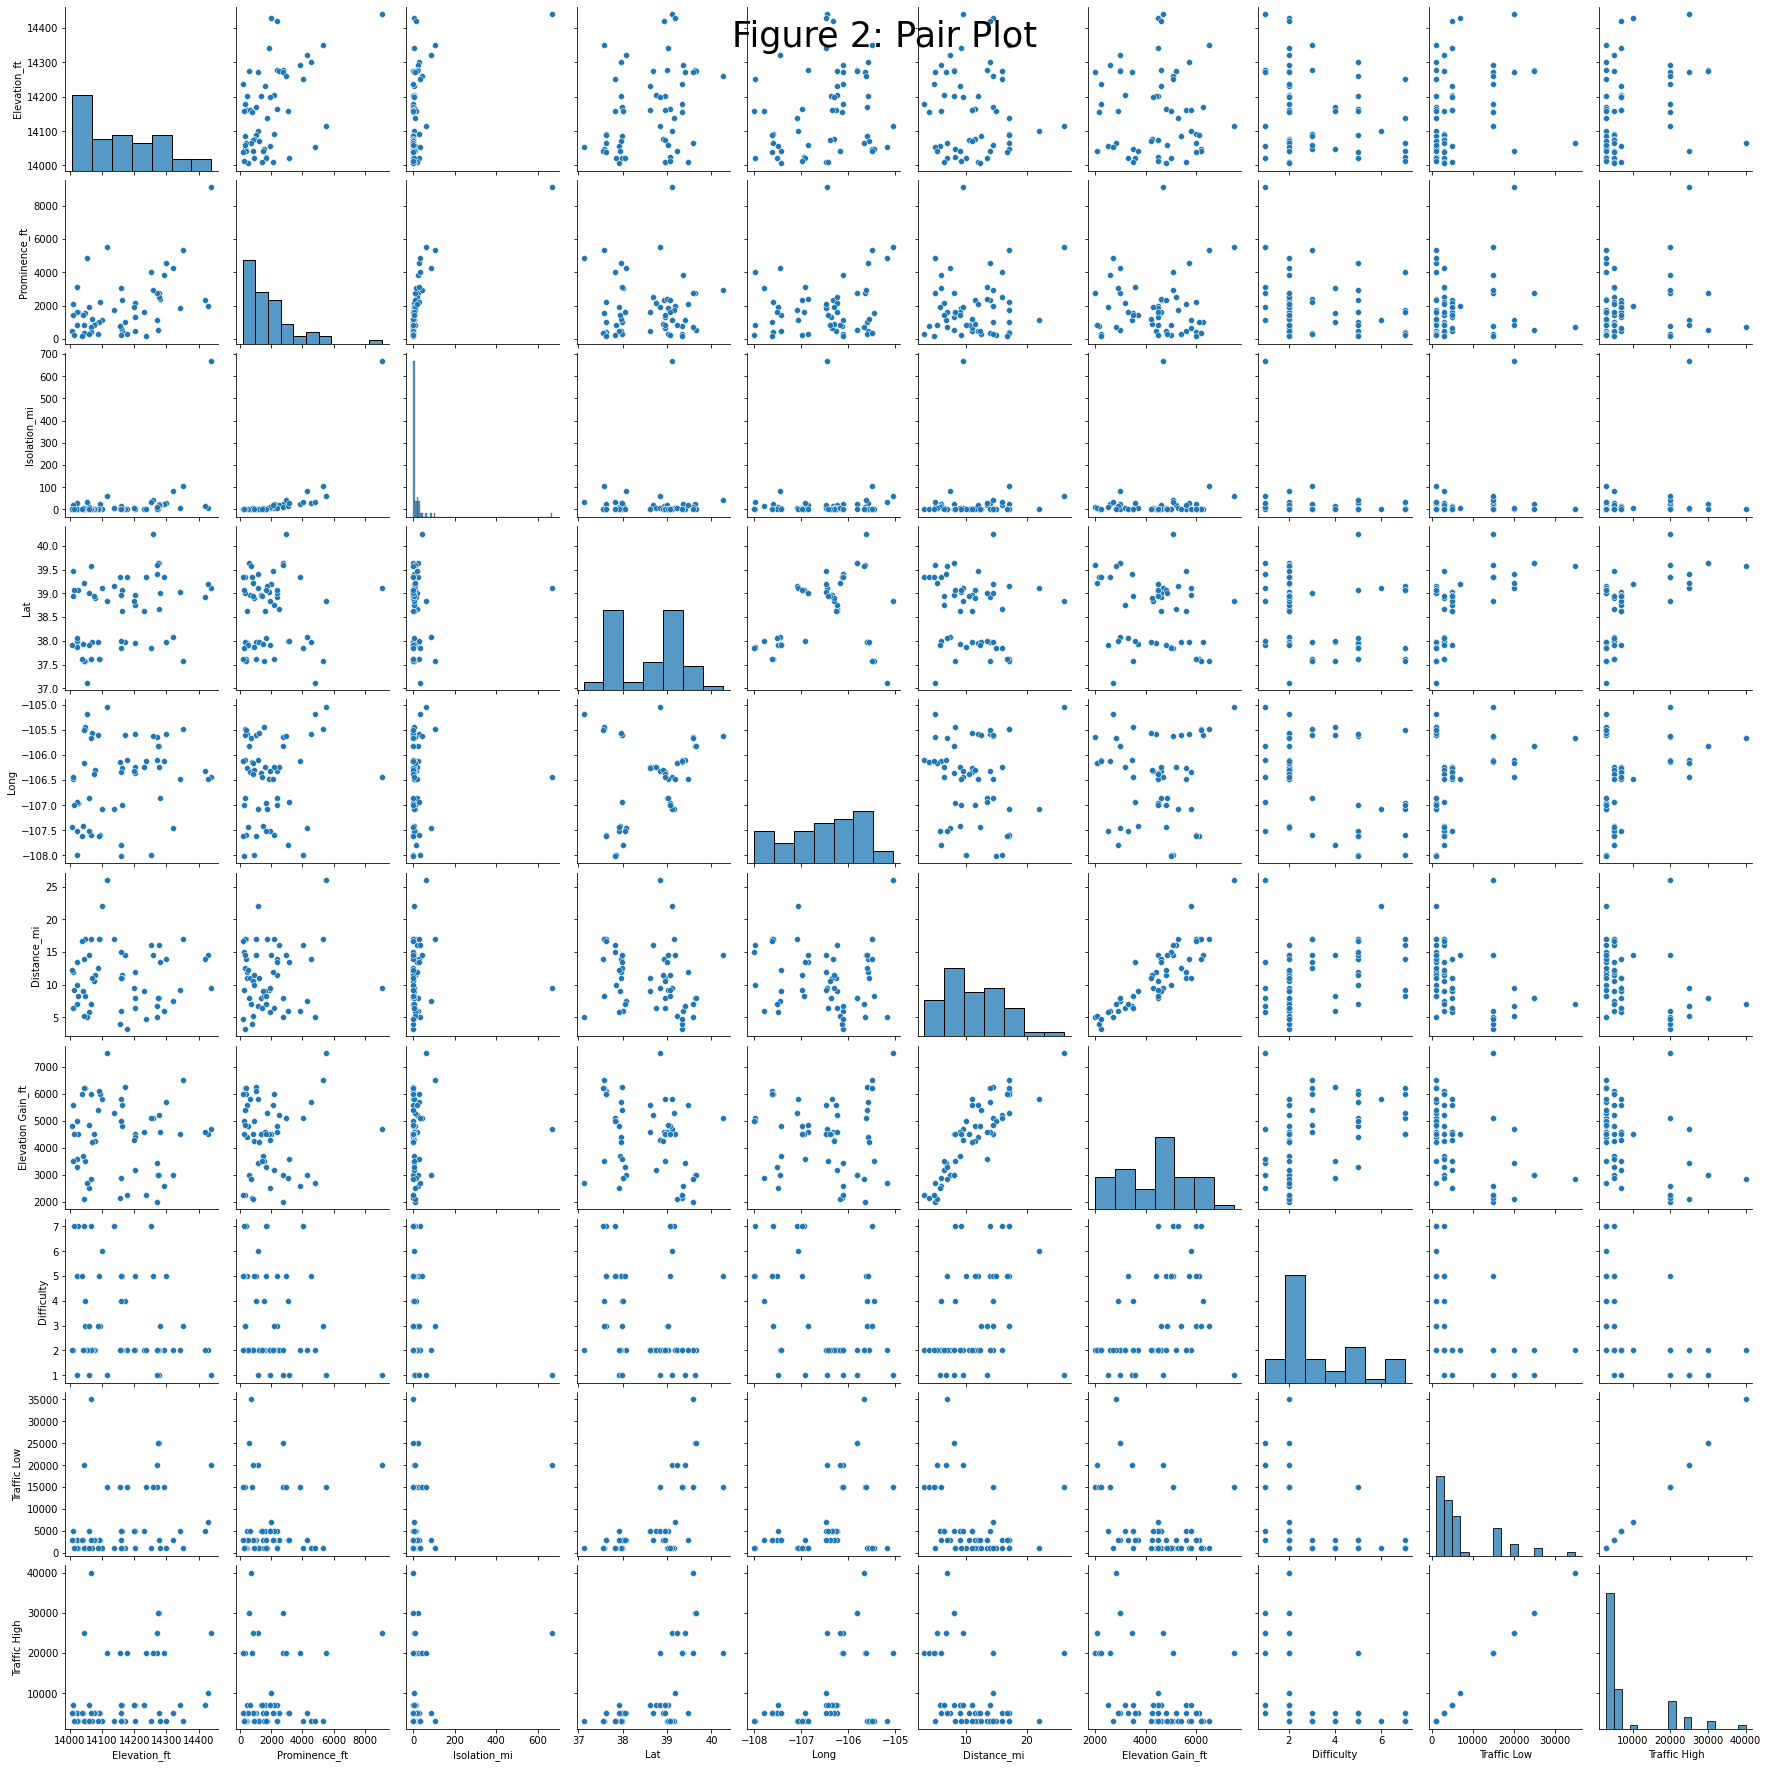

In [33]:
#the only pattern I saw was elevation gain and mileage
pp = sns.pairplot(df_modeling)
pp.fig.suptitle('Figure 2: Pair Plot', fontsize=35);

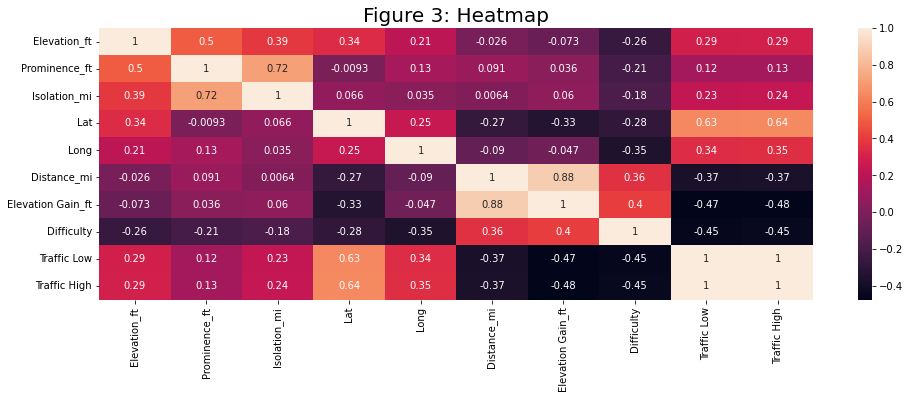

In [18]:
plt.figure(figsize = (16,5))
sns.heatmap(df_modeling.corr(), annot=True)
plt.title('Figure 3: Heatmap', fontdict={'fontsize': 20});

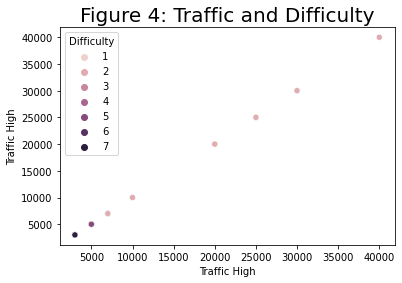

In [19]:
sns.scatterplot(data=df_modeling, x='Traffic High', y='Traffic High', hue='Difficulty')
plt.title('Figure 4: Traffic and Difficulty', fontdict={'fontsize': 20});

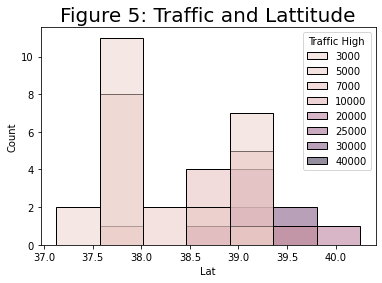

In [20]:
sns.histplot(data=df_modeling, x="Lat", hue='Traffic High')
plt.title('Figure 5: Traffic and Lattitude', fontdict={'fontsize': 20});

# Plotting Locations and I-70

In [21]:
import urllib.request
import json
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [22]:
from bs4 import BeautifulSoup

URL = 'https://www.openstreetmap.org/relation/84533#map=8/40.457/-108.133'
soup = BeautifulSoup(urllib.request.urlopen(URL), 'html.parser')

bdiValues_list =  list( soup.find_all('bdi') )

osmidList = []
for i in range( len(bdiValues_list)):
    if (i%2) == 1: 
        osmidList.append( str(bdiValues_list[i].contents[0]) )

In [23]:
baseUrl1 = 'https://nominatim.openstreetmap.org/details.php?osmtype=W&osmid='
baseUrl2 = '&class=highway&addressdetails=1&hierarchy=0&group_hierarchy=1&format=json&polygon_geojson=1'

allCoords = []
for osmid in osmidList[2::]: # the initail values are not relavent to plotting I-70
    coords_URL = baseUrl1+osmid+baseUrl2
    
    res_body = urllib.request.urlopen(coords_URL).read()
    content = json.loads(res_body.decode("utf-8"))
    
    coords = content['geometry']['coordinates']
    allCoords = allCoords + coords

for l in allCoords:
    l.reverse()

## Road and 14ers

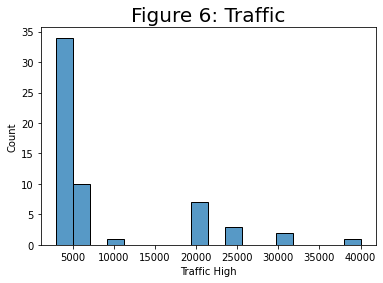

In [24]:
sns.histplot(data=df_modeling, x="Traffic High")
plt.title('Figure 6: Traffic', fontdict={'fontsize': 20});

In [25]:
df_map = df.copy()

df_map['Traffic High'].loc[ df['Traffic High'].between(0, 15000)] = 'Low'
df_map['Traffic High'].loc[ df['Traffic High'].between(15000, 26000)] = 'Medium'
df_map['Traffic High'].loc[ df['Traffic High'].between(26000, 50000)] = 'High'

C:\Users\Trey\Desktop\Python\14er Project\14ervenv\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [26]:
classColor = { 'Low': 'lightblue',
              'Medium': 'green',
              'High': 'red'
             }

In [27]:
m = folium.Map(location=[39.0236, -105.0050], zoom_start=7)

interstate =folium.vector_layers.PolyLine(locations=allCoords[0:8850], color='blue', weight=5)

for i in range( len(df) ):
    
    folium.Marker(
        [df_map.iloc[i][6], df_map.iloc[i][7]], popup="<b>"+df_map.iloc[i][0]+"</b>", icon=folium.Icon(color=classColor[df_map.iloc[i][13]], icon="Mountain")
    ).add_to(m)

m.add_child(interstate)

In [28]:
from branca.element import Template, MacroElement

template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>Traffic</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:lightblue;opacity:0.7;'></span>Low</li>
    <li><span style='background:green;opacity:0.7;'></span>Medium</li>
    <li><span style='background:red;opacity:0.7;'></span>High</li>

  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

macro = MacroElement()
macro._template = Template(template)

m.get_root().add_child(macro)

m

## Modeling
The linear reggression model I made is not good for predicting how much traffic a 14er will see. With an adjusted R-squared of 0.493 this model predicts almost 50% of the variation in 14er traffic. Perhaps it is a good start, but more dimensions would be needed for a reliable model!

In [29]:
import statsmodels.api as sm 
#from statsmodels.graphics.api import abline_plot 
#from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.model_selection import train_test_split 
#from sklearn import linear_model, preprocessing 

In [30]:
X = df_modeling[["Difficulty", "Lat"]]

X = sm.add_constant(X)
y = df_modeling[["Traffic High"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123)

In [31]:
rModel3 = sm.OLS(y_train, X_train)
# Fit the model
rModel3_results = rModel3.fit()
rModel3_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Traffic High   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     21.39
Date:                Sun, 24 Oct 2021   Prob (F-statistic):           4.82e-07
Time:                        18:14:58   Log-Likelihood:                -427.74
No. Observations:                  43   AIC:                             861.5
Df Residuals:                      40   BIC:                             866.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.197e+05   4.57e+04     -4.803      0.000   -3.12e+05   -1.27e+05
Difficulty -1027.1085    427.112     -2.405      0.021   -1890.335    -163.882
Lat         6000.5222   1175.946      5.103      0.000    3623.846    8377.198
==============================================================================
Omnibus:                        3.052   Durbin-Watson:                   2.201
Prob(Omnibus):                  0.217   Jarque-Bera (JB):                2.816
Skew:                           0.608   Prob(JB):                        0.245
Kurtosis:                       2.694   Cond. No.                     2.21e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.21e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""